***BGS Core Machine learning project - using unet as implemented by fastai***

Cleaned up version that will run standalone (up to a point!)

In [36]:
import os
from pathlib import Path
from functools import partial
CUDA_LAUNCH_BLOCKING="1"  # better error reporting
import warnings
warnings.filterwarnings("ignore") # suppress pytorch warnings

In [37]:
%matplotlib inline


In [38]:
from fastai.vision import imagenet_stats, DatasetType
from fastai.vision.data import get_image_files, SegmentationItemList
from fastai.vision.image import open_mask
from fastai.vision.learner import unet_learner
from fastai.vision.transform import get_transforms
from fastai.vision import models

import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from corescore.masks import LABELS

In [39]:
path = Path(os.getcwd())
path_lbl = path / 'Images/train_masks'
path_img = path / 'Images/train'


**Load Data and Check Directories**

In [40]:
fnames = get_image_files(path_img)
len(fnames)

8

In [41]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

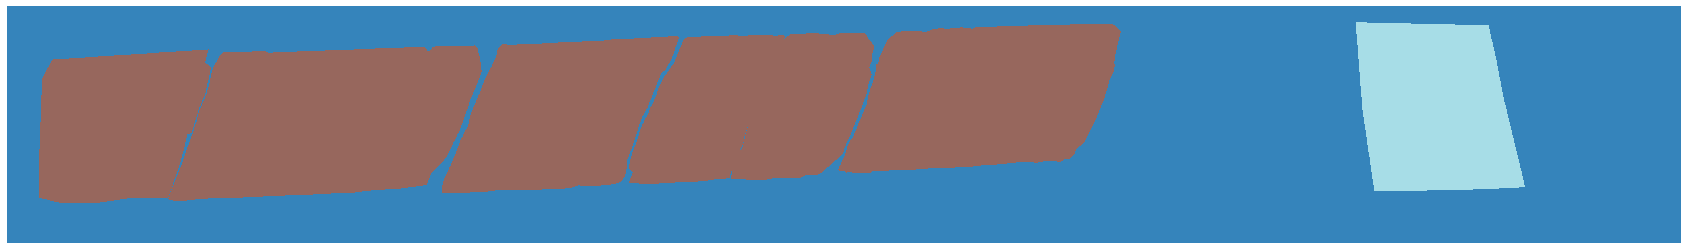

In [42]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(30,30), alpha=0.9)

In [43]:
src_size = np.array(mask.shape[1:])
reduce_size = np.array([360,2480]) # why these values?
reduce_size = np.array([148,1048]) # why these values?
batch_size = 1

In [44]:
src_size / 6


array([ 148., 1048.])

In [45]:
src = (SegmentationItemList.from_folder(path_img).split_by_rand_pct().label_from_func(get_y_fn, classes=LABELS))

In [46]:
src.train.y.create_func = partial(open_mask, div=True)
src.valid.y.create_func = partial(open_mask, div=True)

In [47]:
data = (src.transform(get_transforms(), size=reduce_size, tfm_y=True)
        .databunch(bs=batch_size, num_workers=0) # set 0 to avoid ForkingPickler pipe error
        .normalize(imagenet_stats))

*Show part of validation set and the training data*

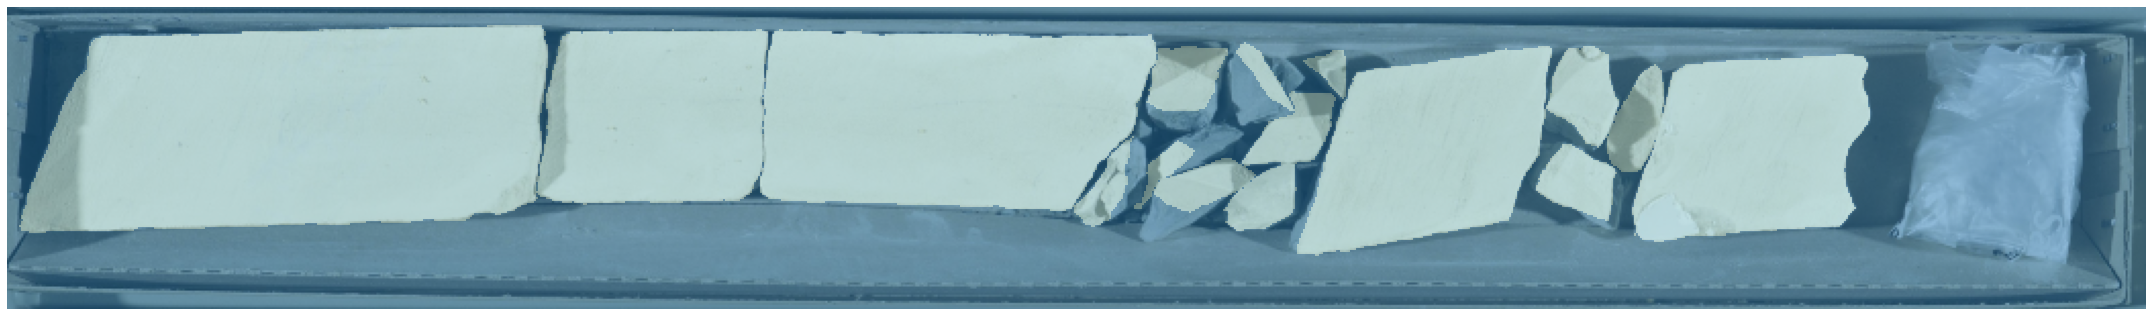

In [48]:
data.show_batch(1, figsize=(30,30), ds_type=DatasetType.Valid)

*Accuracy metric like what is implemented in the fastai tutorial - needs to be changed eventually*

In [49]:

def acc_rock(input, target):
    target = target.squeeze(1)
    mask = target != LABELS.index("Void")
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [50]:
metrics=acc_rock

In [51]:
wd=1e-2 # why this value

*Setup learner and find optimal learning rate*

In [52]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


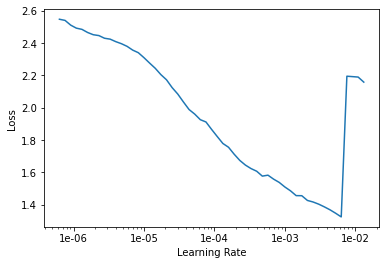

In [53]:
torch.cuda.empty_cache()
lr = learn.lr_find()
learn.recorder.plot()


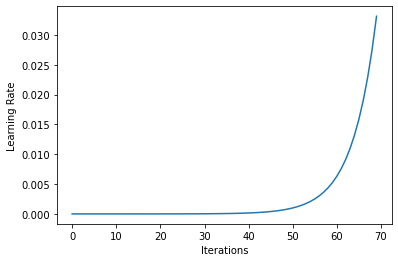

In [54]:
lr=5.20E-05 # why this value?
lr = 1E-02
learn.recorder.plot_lr()

In [55]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_rock,time
0,4.491064,1.143198,0.468814,00:04
1,2.615003,0.892749,0.579327,00:04
2,1.900656,0.592781,0.839553,00:04
3,1.542004,1.587329,0.574698,00:04
4,1.288395,0.755044,0.700698,00:04
5,1.273926,1.083116,0.601132,00:04
6,1.262074,1.177755,0.474778,00:04
7,1.174792,2.428123,0.503656,00:04
8,13.678754,4.546846,0.488214,00:04
9,4953.528320,3.659541,0.536846,00:04


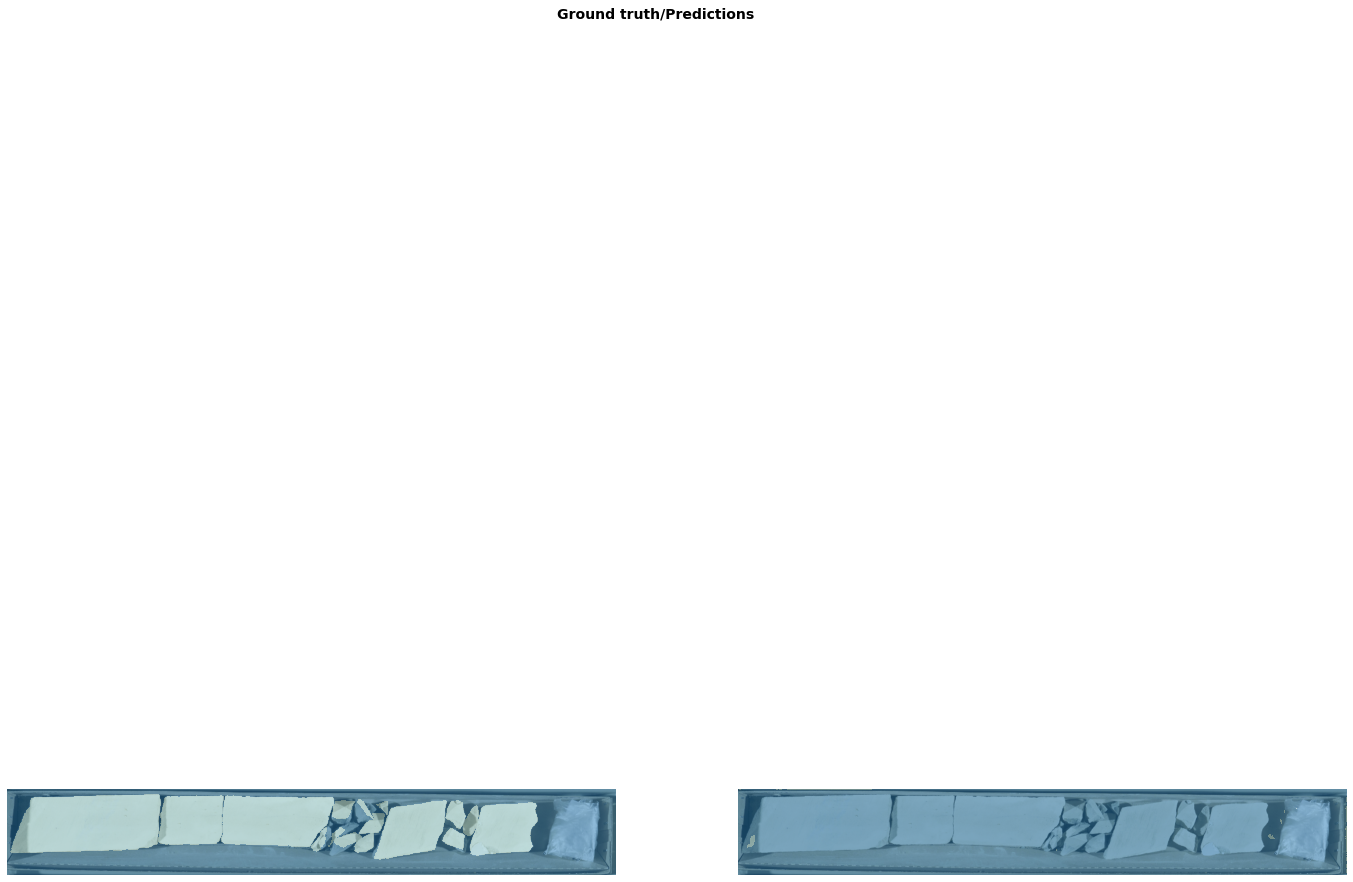

In [56]:
learn.show_results(rows=2, figsize=(24,24))
#plt.savefig("results_with__no_Synthetic_Data.pdf")

In [57]:
lrs = slice(lr/400,lr/4)

In [58]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_rock,time
0,1.426118,3.407767,0.535267,00:04
1,1.368160,2.303681,0.512050,00:05
2,1.234975,1.780773,0.366992,00:05
3,1.166276,1.183175,0.438635,00:05
4,1.046839,0.951729,0.374987,00:05
5,0.962108,0.804776,0.436804,00:05
6,0.879605,1.479834,0.437384,00:05
7,0.820383,1.030620,0.522836,00:04
8,0.801159,0.593693,0.801056,00:05
9,0.760226,0.838992,0.628088,00:04


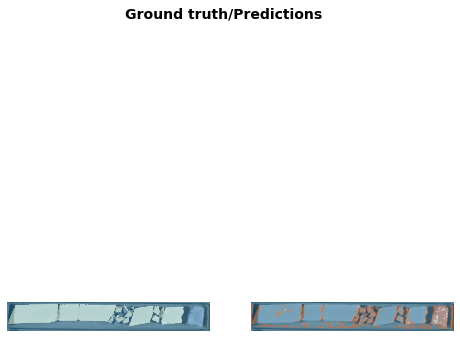

In [59]:
learn.show_results(rows=2, figsize=(8,9))

***Final training with the larger images***

In [60]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_rock,time
0,0.425879,1.449722,0.489014,00:05
1,0.420444,1.734542,0.441381,00:05
2,0.428108,1.124130,0.522585,00:05
3,0.418150,1.536741,0.489768,00:05
4,0.414540,1.876626,0.413484,00:04
5,0.399833,1.653329,0.357122,00:05
6,0.389855,1.371846,0.449157,00:05
7,0.386196,1.510462,0.482599,00:05
8,0.381024,1.301262,0.456004,00:05
9,0.372414,1.299474,0.442245,00:05


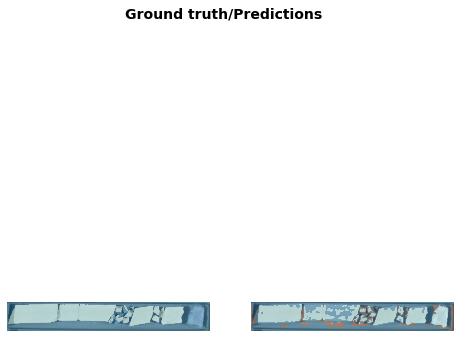

In [61]:
learn.show_results(rows=2, figsize=(8,9))